# Import necessary libs

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [34]:
import cv2
import extcolors

from colormap import rgb2hex

Fix 'sc' namespace not defined

In [35]:
from pyspark import SparkContext
sc =SparkContext()


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at /tmp/ipykernel_310252/3713497126.py:2 

# Get 'fish' data from spark and thunder

In [36]:
from thunder import images
data = images.fromrandom(engine=sc)
data

Images
mode: spark
dtype: float64
shape: (10, 50, 50)

In [37]:
import matplotlib.pyplot as plt
from showit import image, tile
import thunder as td


In [38]:
data = td.images.fromexample('fish')
data

Images
mode: local
dtype: uint8
shape: (20, 2, 76, 87)

([<matplotlib.image.AxesImage at 0x7f18237cd8b0>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f182448b460>)

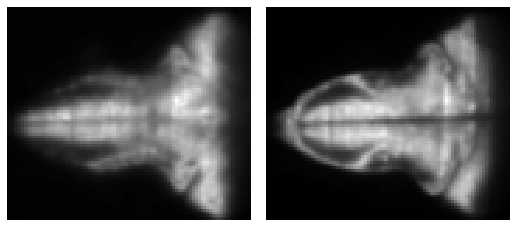

In [39]:
tile(data[0])

# Saving fish image to project

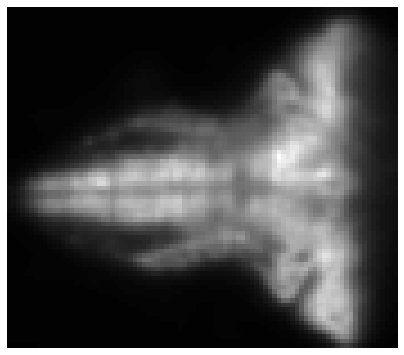

In [40]:
subnet = data[0,0]
image(subnet)

In [41]:
from numpy import asarray

In [42]:
print(subnet)

Images
mode: local
dtype: uint8
shape: (1, 1, 76, 87)


In [43]:
subnet = asarray(subnet)
subnet

array([[26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 27, 27, 26],
       ...,
       [26, 26, 26, ..., 27, 27, 26],
       [26, 26, 26, ..., 27, 26, 26],
       [25, 25, 25, ..., 26, 26, 26]], dtype=uint8)

In [44]:
subnet.shape

(76, 87)

In [45]:
fishIm = Image.fromarray(subnet)

In [46]:
fishIm.save("fish.jpg")

# Blending fish and selfie 

### Load selfie 

In [47]:
Im = Image.open("test.jpg")
print(Im.mode,Im.size,Im.format)
Im.show()

RGB (1043, 1293) JPEG


### Load fish

In [48]:
Im2 = Image.open("fish.jpg").convert(Im.mode)
Im2 = Im2.resize(Im.size)
Im2.show()

### Blend and save 

In [49]:
Blendimg = Image.blend(Im,Im2,0.5)
Blendimg.show()
Blendimg.save("blend.jpg")

# Extract dominant colors

In [50]:
input_name = 'blend'

In [51]:
def color_to_df(input):
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    return df



def exact_color(input_image, resize, tolerance, zoom):
    #background
    bg = 'bg.png'
    fig, ax = plt.subplots(figsize=(192,108),dpi=10)
    fig.set_facecolor('white')
    plt.savefig(bg)
    plt.close(fig)
    
    #resize
    output_width = resize
    img = Image.open(input_image)
    if img.size[0] >= resize:
        wpercent = (output_width/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((output_width,hsize), Image.ANTIALIAS)
        resize_name = 'resize_'+ input_image
        img.save(resize_name)
    else:
        resize_name = input_image
    
    #crate dataframe
    img_url = resize_name
    colorsX = extcolors.extract_from_path(img_url, tolerance = tolerance, limit = 13)
    df_color = color_to_df(colorsX)
    
    #annotate text
    list_color = list(df_color['c_code'])
    list_precent = [int(i) for i in list(df_color['occurence'])]
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color, list_precent)]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(160,120), dpi = 10)
    
    #donut plot
    wedges, text = ax1.pie(list_precent,
                           labels= text_c,
                           labeldistance= 1.05,
                           colors = list_color,
                           textprops={'fontsize': 150, 'color':'black'})
    plt.setp(wedges, width=0.3)

    #add image in the center of donut plot
    img = mpimg.imread(resize_name)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (0, 0))
    ax1.add_artist(ab)
    
    #color palette
    x_posi, y_posi, y_posi2 = 160, -170, -170
    for c in list_color:
        if list_color.index(c) <= 5:
            y_posi += 180
            rect = patches.Rectangle((x_posi, y_posi), 360, 160, facecolor = c)
            ax2.add_patch(rect)
            ax2.text(x = x_posi+400, y = y_posi+100, s = c, fontdict={'fontsize': 190})
        else:
            y_posi2 += 180
            rect = patches.Rectangle((x_posi + 1000, y_posi2), 360, 160, facecolor = c)
            ax2.add_artist(rect)
            ax2.text(x = x_posi+1400, y = y_posi2+100, s = c, fontdict={'fontsize': 190})

    fig.set_facecolor('white')
    ax2.axis('off')
    bg = plt.imread('bg.png')
    plt.imshow(bg)       
    plt.tight_layout()
    return plt.show()

/tmp/ipykernel_310252/2903591616.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((output_width,hsize), Image.ANTIALIAS)


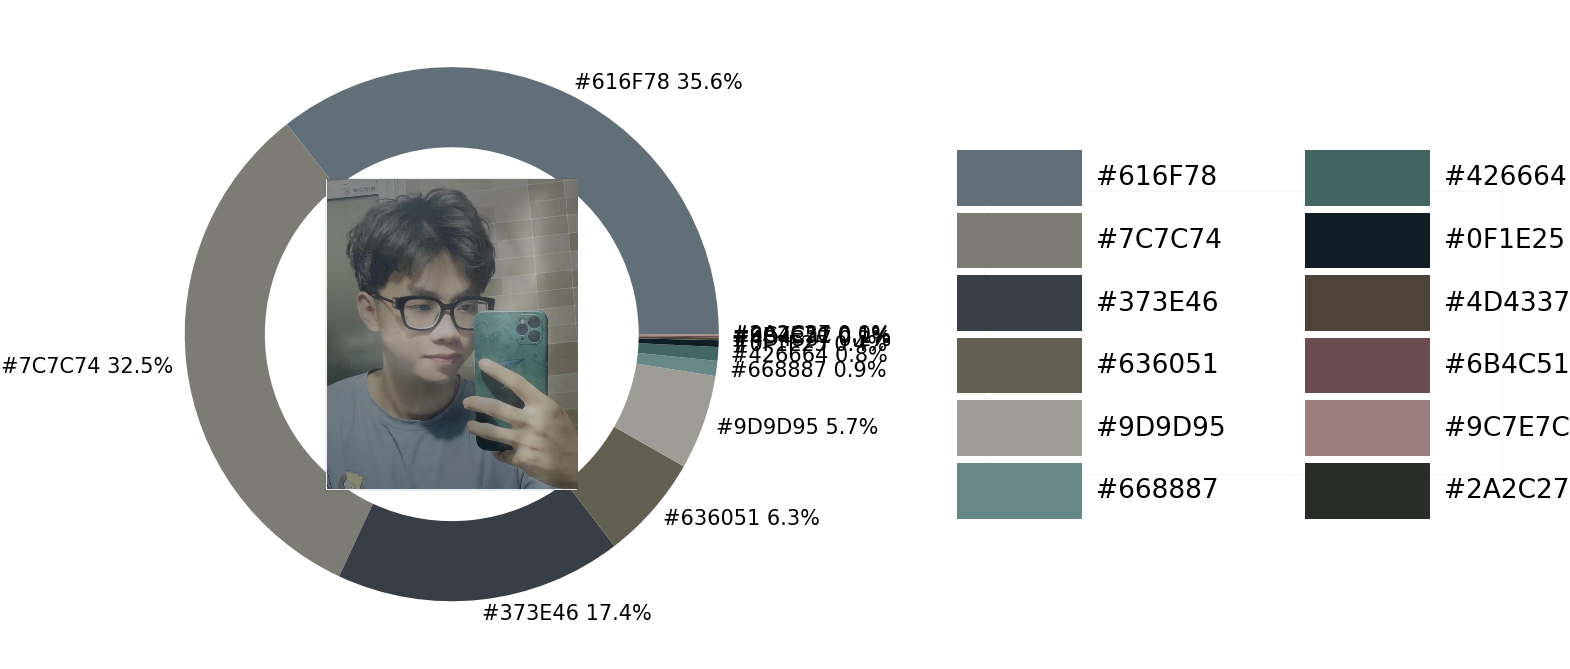

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 49582)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/lib/python3.8/dist-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/local/lib/python3.8/dist-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/usr/local/lib/python3.8/dist-packages/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/lo

In [52]:
exact_color(input_name + ".jpg", 900, 12, 2)